# 基于 TensorFlow 在 SecretFlow 中实现水平联邦 RNN 生成音乐任务
## 引言
本教程基于 TensorFlow 的 [使用 RNN 生成音乐](https://tensorflow.google.cn/tutorials/audio/music_generation?hl=zh-cn) 而改写，通过本教程，您将了解到现有的基于 TensorFlow 的示例如何快速地迁移到 SecretFlow 隐语的联邦学习框架之下，实现模型的联邦学习化。本教程建议在 Python 版本为`3.8.10`下运行。

## 单机模式
### 小节引言
本小节的代码主要来自于 [使用 RNN 生成音乐](https://tensorflow.google.cn/tutorials/audio/music_generation?hl=zh-cn) ，主要讲解如何使用简单的 RNN 生成音符。您将使用来自 [MAESTRO 数据集](https://magenta.tensorflow.org/datasets/maestro) 的钢琴 MIDI 文件集合来训练模型。给定一系列音符，您的模型将学习预测序列中的下一个音符。可以通过重复调用模型来生成更长的音符序列。 为了教程的简洁，本小节仅仅简要介绍了一下各部分的功能；对于实现的具体解析，请读者移步参考[原教程](https://tensorflow.google.cn/tutorials/audio/music_generation?hl=zh-cn)。
### 安装依赖

In [1]:
!sudo apt install -y fluidsynth

In [2]:
%pip install --upgrade pyfluidsynth

In [3]:
%pip install pretty_midi

In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

2023-10-24 10:16:14.305317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 10:16:14.453229: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-24 10:16:14.457895: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-24 10:16:14.457917: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [5]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

### 下载 Maestro 数据集

In [6]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'maestro-v2.0.0-midi.zip',
        origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
        extract=True,
        cache_dir='.',
        cache_subdir='data',
    )

In [7]:
filenames = glob.glob(str(data_dir / '**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


### 处理 MIDI 文件

In [8]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_01_Track01_wav.midi


In [9]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [10]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[: seconds * _SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [11]:
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [12]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


### 提取音符

In [13]:
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(
        f'{i}: pitch={note.pitch}, note_name={note_name},' f' duration={duration:.4f}'
    )

0: pitch=43, note_name=G2, duration=0.6198
1: pitch=59, note_name=B3, duration=0.6625
2: pitch=50, note_name=D3, duration=0.6833
3: pitch=67, note_name=G4, duration=0.7135
4: pitch=71, note_name=B4, duration=1.6583
5: pitch=66, note_name=F#4, duration=0.0615
6: pitch=60, note_name=C4, duration=0.0938
7: pitch=43, note_name=G2, duration=0.0969
8: pitch=50, note_name=D3, duration=0.0979
9: pitch=69, note_name=A4, duration=0.6417


In [14]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [15]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,71,1.032292,2.690625,0.000000,1.658333
1,43,1.040625,1.660417,0.008333,0.619792
2,59,1.063542,1.726042,0.022917,0.662500
3,50,1.063542,1.746875,0.000000,0.683333
4,67,1.083333,1.796875,0.019792,0.713542


In [16]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['B4', 'G2', 'B3', 'D3', 'G4', 'A4', 'F#4', 'C4', 'G2', 'D3'],
      dtype='<U3')

In [17]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

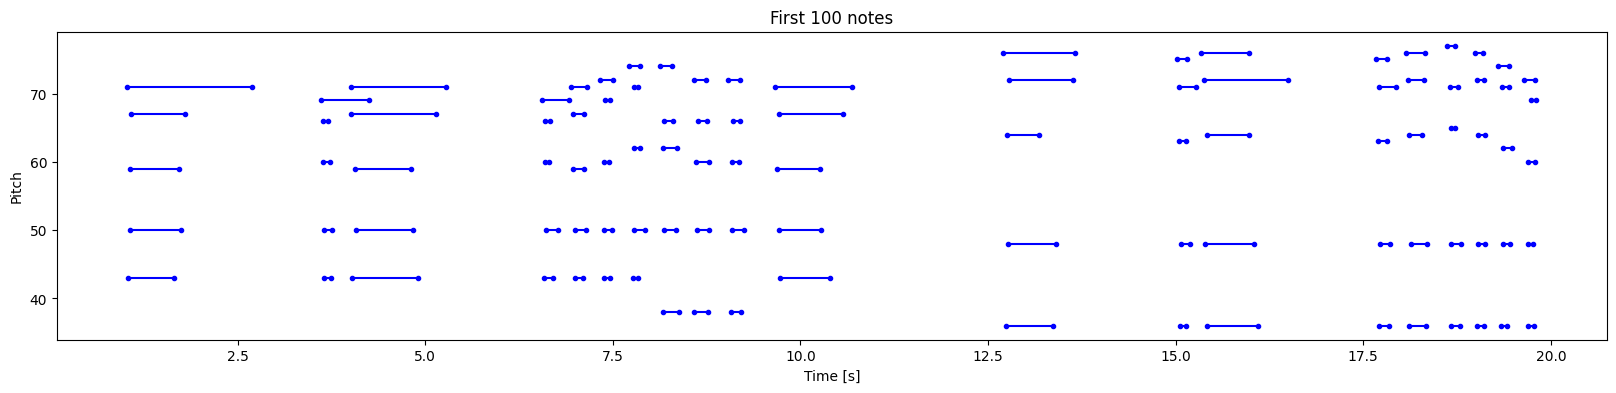

In [18]:
plot_piano_roll(raw_notes, count=100)

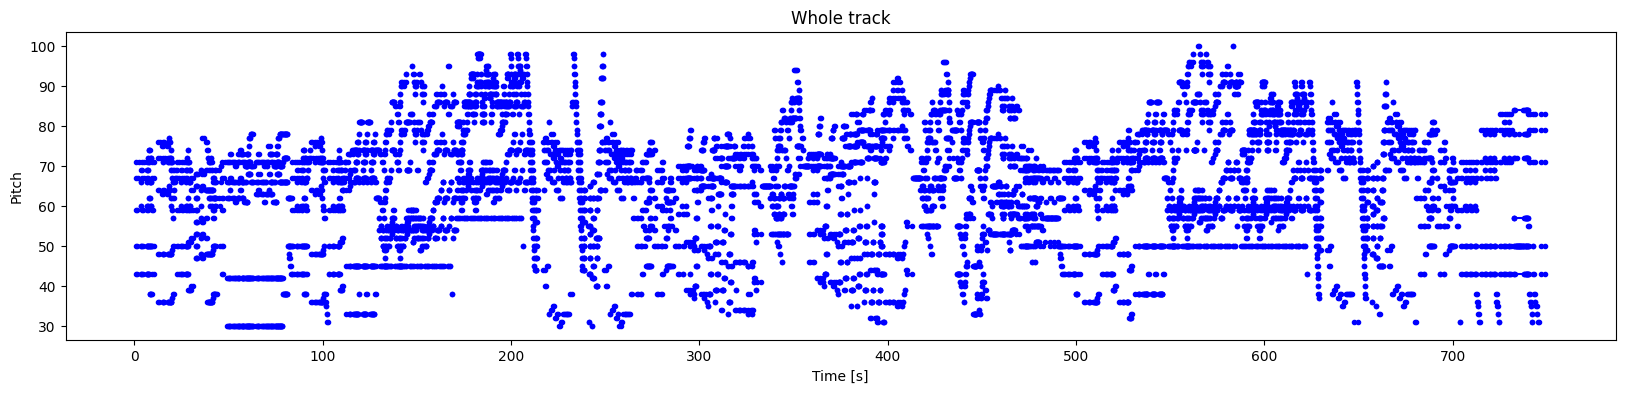

In [19]:
plot_piano_roll(raw_notes)

In [20]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

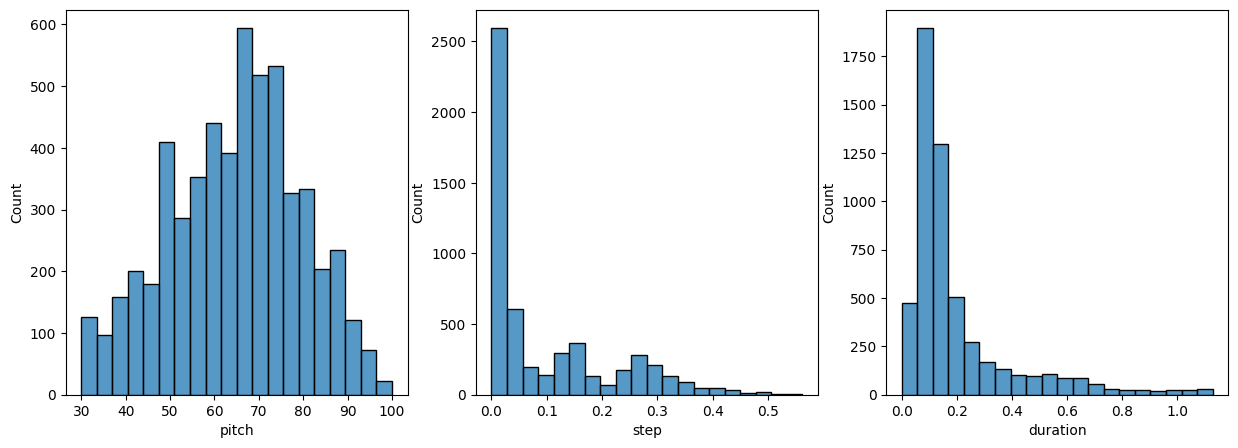

In [21]:
plot_distributions(raw_notes)

### 创建 MIDI 文件

In [22]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str,
    instrument_name: str,
    velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(instrument_name)
    )

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [23]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name
)

In [24]:
display_audio(example_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


### 创建训练数据集

In [25]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [26]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 20519


In [27]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [28]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

2023-10-24 10:16:47.760116: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-24 10:16:47.760197: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-10-24 10:16:47.760240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-10-24 10:16:47.760281: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-10-24 10:16:47.801063: W tensorfl

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [29]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size=128,
) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length + 1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x / [vocab_size, 1.0, 1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key: labels_dense[i] for i, key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [30]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [31]:
for seq, target in seq_ds.take(1):
    print('sequence shape:', seq.shape)
    print('sequence elements (first 10):', seq[0:10])
    print()
    print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.2890625  0.         8.77395833]
 [0.3125     0.25       8.36041667]
 [0.3515625  0.21041667 8.328125  ]
 [0.3828125  0.240625   0.796875  ]
 [0.40625    0.28125    0.640625  ]
 [0.4453125  0.371875   0.50416667]
 [0.4765625  3.1125     0.18645833]
 [0.5        1.62708333 0.221875  ]
 [0.5390625  2.02395833 0.384375  ]
 [0.5390625  5.21145833 0.125     ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=49.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.00416666666666643>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.07395833333333357>}


In [32]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (
    seq_ds.shuffle(buffer_size)
    .batch(batch_size, drop_remainder=True)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [33]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

### 创建并训练模型

In [34]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [35]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [36]:
losses = model.evaluate(train_ds, return_dict=True)
losses

320/320 [==============================] - 7s 16ms/step - loss: 6.1872 - duration_loss: 1.1381 - pitch_loss: 4.8636 - step_loss: 0.1855


{'loss': 6.187170505523682,
 'duration_loss': 1.1380559206008911,
 'pitch_loss': 4.863645553588867,
 'step_loss': 0.18546634912490845}

In [37]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration': 1.0,
    },
    optimizer=optimizer,
)

In [38]:
model.evaluate(train_ds, return_dict=True)

320/320 [==============================] - 5s 14ms/step - loss: 1.5667 - duration_loss: 1.1381 - pitch_loss: 4.8636 - step_loss: 0.1855


{'loss': 1.5667041540145874,
 'duration_loss': 1.1380559206008911,
 'pitch_loss': 4.863645553588867,
 'step_loss': 0.18546634912490845}

In [39]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}', save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=5, verbose=1, restore_best_weights=True
    ),
]

In [40]:
%%time
epochs = 20

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/20
320/320 [==============================] - 11s 29ms/step - loss: 0.6930 - duration_loss: 0.4127 - pitch_loss: 4.0828 - step_loss: 0.0762
Epoch 2/20
320/320 [==============================] - 9s 29ms/step - loss: 0.6176 - duration_loss: 0.3497 - pitch_loss: 3.9135 - step_loss: 0.0722
Epoch 3/20
320/320 [==============================] - 9s 28ms/step - loss: 0.5876 - duration_loss: 0.3181 - pitch_loss: 3.9001 - step_loss: 0.0745
Epoch 4/20
320/320 [==============================] - 9s 29ms/step - loss: 0.5558 - duration_loss: 0.2933 - pitch_loss: 3.8884 - step_loss: 0.0681
Epoch 5/20
320/320 [==============================] - 9s 29ms/step - loss: 0.5423 - duration_loss: 0.2818 - pitch_loss: 3.8813 - step_loss: 0.0664
Epoch 6/20
320/320 [==============================] - 9s 28ms/step - loss: 0.5292 - duration_loss: 0.2699 - pitch_loss: 3.8772 - step_loss: 0.0655
Epoch 7/20
320/320 [==============================] - 9s 29ms/step - loss: 0.5163 - duration_loss: 0.2576 - pitch_los

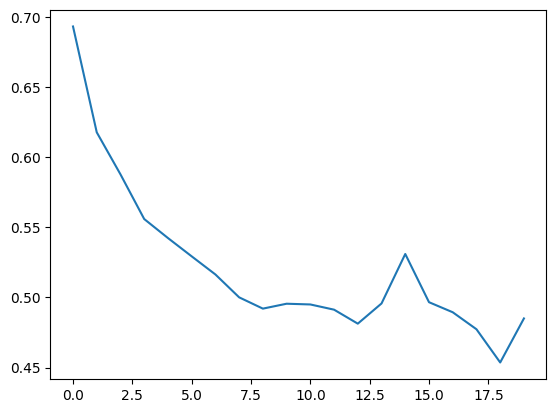

In [41]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

### 生成音符

In [42]:
def predict_next_note(
    notes: np.ndarray, keras_model: tf.keras.Model, temperature: float = 1.0
):
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [43]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = sample_notes[:seq_length] / np.array([vocab_size, 1, 1])

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 25ms/step


In [44]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,62,0.151963,0.231074,0.151963,0.383038
1,86,0.009673,0.000000,0.161637,0.161637
2,86,0.032298,0.000000,0.193935,0.193935
3,69,0.000000,0.000000,0.193935,0.193935
4,74,0.000000,0.000000,0.193935,0.193935
5,71,0.000000,0.000000,0.193935,0.193935
6,62,0.000000,0.000000,0.193935,0.193935
7,74,0.000000,0.000000,0.193935,0.193935
8,36,0.000000,0.000000,0.193935,0.193935
9,74,0.000000,0.000000,0.193935,0.193935


In [45]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name
)
display_audio(out_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


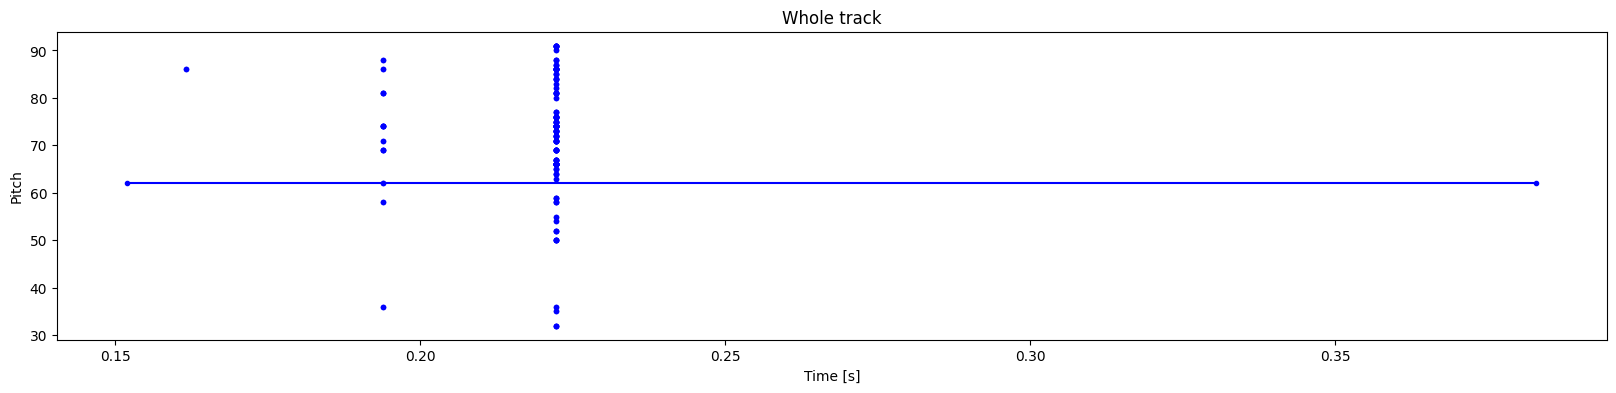

In [46]:
plot_piano_roll(generated_notes)

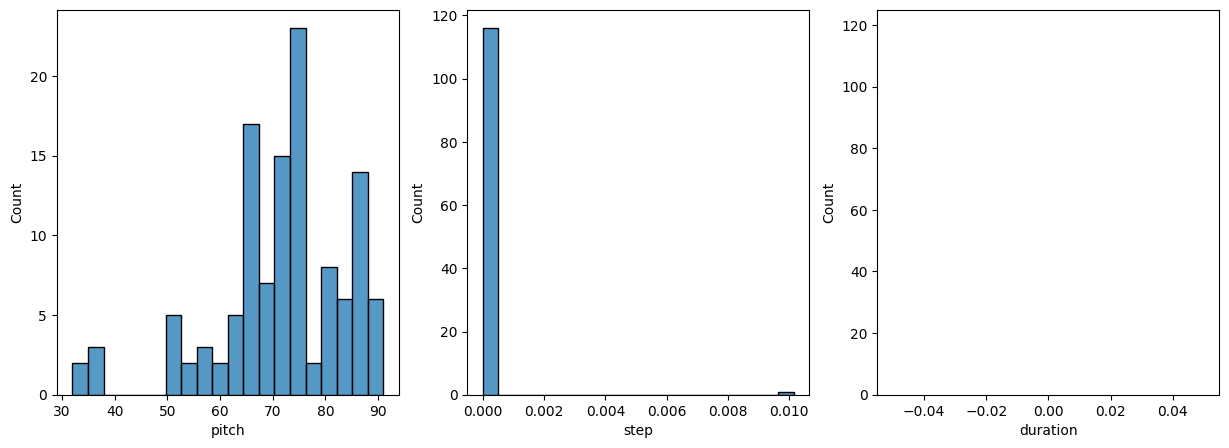

In [47]:
plot_distributions(generated_notes)

## 联邦模式
### 小节引言
通过单机模式，我们已经学会到，如何在单机模式下使用 RNN 生成音符，本节我们将看到如何将单机模型如何快速和低成本地迁移到 SecretFlow 隐语的联邦学习框架之下。

In [48]:
%load_ext autoreload
%autoreload 2

### 隐语环境初始化

In [49]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()
sf.init(['alice', 'bob', 'charlie'], address="local", log_to_driver=False)
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.2.0.dev20231009


2023-10-24 10:20:20,635	INFO worker.py:1538 -- Started a local Ray instance.


### 封装 DataBuilder
在迁移过程，对于数据集的预处理方式，联邦学习模式和单机模式是一样的，我们不再重复。为了完成迁移适配过程，我们只需要参考[在 SecretFlow 中使用自定义 DataBuilder（TensorFlow）](https://github.com/secretflow/secretflow/blob/main/docs/tutorial/CustomDataLoaderTF.ipynb) 封装我们自定义 DataBuilder 即可。现在，参考原教程，我们封装对应的DataBuilder，所以我们也不需要额外写很多代码。

In [50]:
def create_dataset_builder(
    batch_size=32,
):
    def dataset_builder(filenames, stage="train"):
        import math
        import tensorflow as tf

        num_files = 5
        all_notes = []
        for f in filenames[:num_files]:
            notes = midi_to_notes(f)
            all_notes.append(notes)

        all_notes = pd.concat(all_notes)
        n_notes = len(all_notes)

        key_order = ['pitch', 'step', 'duration']
        train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

        notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)

        seq_length = 25
        vocab_size = 128
        seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

        buffer_size = n_notes - seq_length  # the number of items in the dataset
        train_ds = (
            seq_ds.shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE)
        )

        if stage == "train":
            train_dataset = train_ds
            # train_step_per_epoch = math.ceil(n_notes / batch_size)
            train_step_per_epoch = 160
            return train_dataset, train_step_per_epoch
        elif stage == "eval":
            eval_dataset = train_ds
            eval_step_per_epoch = 160
            return eval_dataset, eval_step_per_epoch

    return dataset_builder

### 定义网络结构
得益于隐语优异的设计，我们只需要将单机模式下定义的网络结构，进行适当的封装即可。具体到本教程，我们只需要对单机模式的模型进行封装即可。

In [51]:
def create_audio_generate_model(input_shape, name='model'):
    def create_model():
        from tensorflow import keras

        # Create model

        inputs = tf.keras.Input(input_shape)
        x = tf.keras.layers.LSTM(128)(inputs)

        outputs = {
            'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
            'step': tf.keras.layers.Dense(1, name='step')(x),
            'duration': tf.keras.layers.Dense(1, name='duration')(x),
        }

        model = tf.keras.Model(inputs, outputs)

        loss = {
            'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'step': mse_with_positive_pressure,
            'duration': mse_with_positive_pressure,
        }
        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
        model.compile(loss=loss, optimizer=optimizer)

        return model

    return create_model

### 定义 TensorFlow 后端的 FLModel 

In [52]:
from secretflow.ml.nn import FLModel
from secretflow.security.aggregation import SecureAggregator

In [53]:
device_list = [alice, bob]
aggregator = SecureAggregator(charlie, [alice, bob])

# prepare model
input_shape = (seq_length, 3)

# keras model
model = create_audio_generate_model(input_shape)


fed_model = FLModel(
    device_list=device_list,
    model=model,
    aggregator=aggregator,
    backend="tensorflow",
    strategy="fed_avg_w",
    random_seed=1234,
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [54]:
data_builder_dict = {
    alice: create_dataset_builder(
        batch_size=32,
    ),
    bob: create_dataset_builder(
        batch_size=32,
    ),
}

### 给出参与方数据集路径
#### 查看数据集结构

In [55]:
len(filenames)

1282

In [56]:
filenames[:10]

['data/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_21_R1_2004_02_ORIG_MID--AUDIO_21_R1_2004_02_Track02_wav.midi',
 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_01_Track01_wav.midi',
 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_02_Track02_wav.midi',
 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_17_R1_2004_01-02_ORIG_MID--AUDIO_20_R2_2004_04_Track04_wav.midi',
 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_02_Track02_wav.midi',
 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_04_R1_2004_06_ORIG_MID--AUDIO_04_R1_2004_08_Track08_wav.midi',
 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_17_R1_2004_04_ORIG_MID--AUDIO_17_R1_2004_11_Track11_wav.midi',
 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_10_Track10_wav.midi',
 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_05_R1_2004_02-03_ORIG_MID--AUDIO_05_R1_2004_06_Track06_wav.midi

可以看到，我们的数据集路径保存在变量 **filenames** 里，并且一共是 **1282** 个文件，所以我们直接将这份列表一分为二，模拟联邦学习的数据拥有方是 **alice** 和 **bob**

In [57]:
len_dataset = len(filenames)
alice_filenames_dataset = filenames[: int(len_dataset / 2)]
bob_filenames_dataset = filenames[int(len_dataset / 2) :]

分别查看**alice** 和 **bob**的数据集数目

In [58]:
print("the number of samples of Alice: {}".format(len(alice_filenames_dataset)))
print("the number of samples of Bob: {}".format(len(bob_filenames_dataset)))

the number of samples of Alice: 641
the number of samples of Bob: 641


In [59]:
data = {
    alice: filenames,
    bob: filenames,
}

### 训练联邦学习模型

In [60]:
history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=50,
    batch_size=64,
    aggregate_freq=2,
    sampler_method="batch",
    random_seed=1234,
    dp_spent_step_freq=1,
    dataset_builder=data_builder_dict,
)

INFO:root:FL Train Params: {'x': {PYURuntime(alice): ['data/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_21_R1_2004_02_ORIG_MID--AUDIO_21_R1_2004_02_Track02_wav.midi', 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_01_Track01_wav.midi', 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_02_Track02_wav.midi', 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_17_R1_2004_01-02_ORIG_MID--AUDIO_20_R2_2004_04_Track04_wav.midi', 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_02_Track02_wav.midi', 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_04_R1_2004_06_ORIG_MID--AUDIO_04_R1_2004_08_Track08_wav.midi', 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_17_R1_2004_04_ORIG_MID--AUDIO_17_R1_2004_11_Track11_wav.midi', 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_10_Track10_wav.midi', 'data/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_05_R1_2004_02-03_O

### 可视化训练历史

In [61]:
history.global_history.keys()

dict_keys(['loss', 'duration_loss', 'pitch_loss', 'step_loss', 'val_loss', 'val_duration_loss', 'val_pitch_loss', 'val_step_loss'])

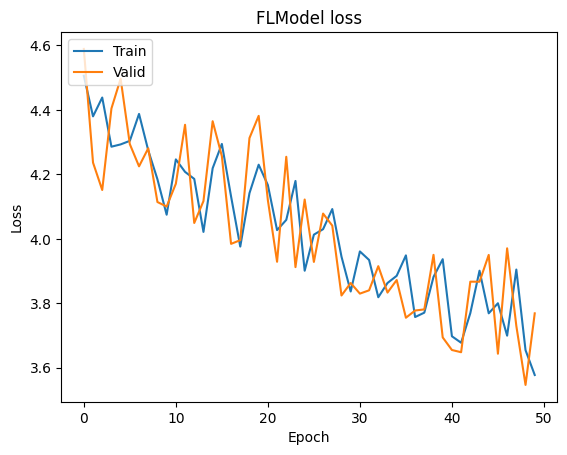

In [62]:
from matplotlib import pyplot as plt

# Draw loss values for training & validation
plt.plot(history.global_history['loss'])
plt.plot(history.global_history['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

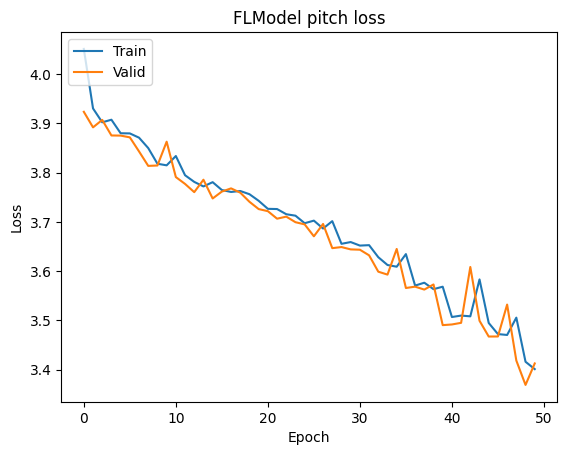

In [63]:
# Draw loss values for training & validation
plt.plot(history.global_history['pitch_loss'])
plt.plot(history.global_history['val_pitch_loss'])
plt.title('FLModel pitch loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

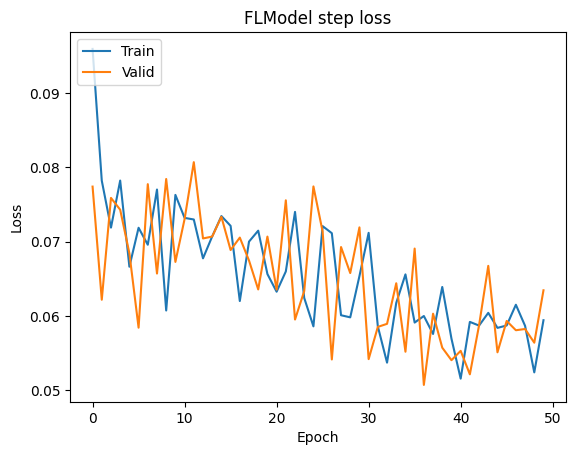

In [64]:
# Draw loss values for training & validation
plt.plot(history.global_history['step_loss'])
plt.plot(history.global_history['val_step_loss'])
plt.title('FLModel step loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

至此，我们很好地完成了联邦学习模型的训练。

## 小结

通过本教程，您将看到，如何将 TensorFlow 的生成音乐模型快速迁移到 SecretFlow 隐语 的联邦学习框架之下，实现生成音乐模型的联邦学习。